In [42]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

# --- Database connection details ---
DB_HOST = 'localhost'
DB_USER = 'gmaayan'
DB_PASSWORD = 'j.UyNY.3NsP6vrdfy3LNq.2f'
DB_NAME = 'tweets'

In [43]:
# --- Connect to the database ---
db_connection = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    charset="utf8mb4",
    collation="utf8mb4_unicode_ci"
)

# Create a cursor object
cursor = db_connection.cursor()

In [24]:
# --- Define your query ---
query = """
SELECT
  noteId,
  COUNT(*) AS note_count
FROM note_ratings
WHERE helpfulnessLevel = HELPFUL
GROUP BY noteId
ORDER BY note_count DESC;
"""

# --- Execute the query ---
cursor.execute(query)

# Fetch all results
results = cursor.fetchall()

# store the results in a pandas dataframe
df2 = pd.DataFrame(results, columns=['noteId', 'note_count'])

print(df2.head())

                noteId  note_count
0  1681713296271892480       20086
1  1727782563186618856       13309
2  1649126162742771733       11414
3  1661796202554294297       11334
4  1641632910263431169        9662


In [25]:
print(df.head())
print(df.equals(df2))

               note_id  note_count
0  1681713296271892480       20086
1  1727782563186618856       13309
2  1649126162742771733       11414
3  1661796202554294297       11334
4  1641632910263431169        9662
False


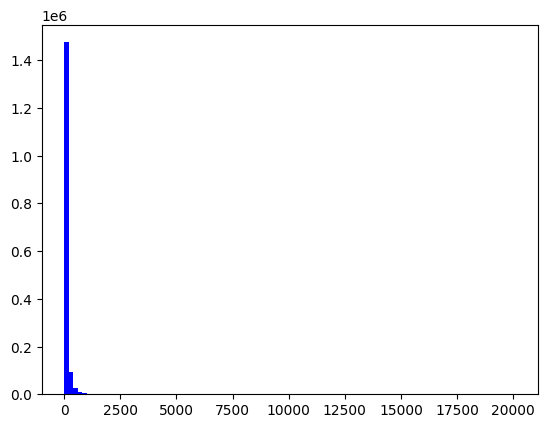

In [16]:
query = """
SELECT agree, disagree, helpfulnessLevel, helpful FROM note_ratings
WHERE noteId = 1681713296271892480
"""

cursor.execute(query)
results = cursor.fetchall()
df3 = pd.DataFrame(results, columns=['agree', 'disagree', 'helpfulnessLevel', 'helpful'])

# plot histogram of note counts
plt.hist(df['note_count'], bins=100, color='blue')
plt.show()

In [51]:
print(df3.head())
print(df3['helpfulnessLevel'].value_counts())

   agree  disagree helpfulnessLevel  helpful
0      0         0          HELPFUL        0
1      0         0          HELPFUL        0
2      0         0          HELPFUL        0
3      0         0          HELPFUL        0
4      0         0          HELPFUL        0
helpfulnessLevel
HELPFUL             19629
NOT_HELPFUL           344
SOMEWHAT_HELPFUL      113
Name: count, dtype: int64


In [27]:
df4 = df2[df2['note_count'] > 500]
print(df4.shape)

(33530, 2)


In [35]:
query = """
SELECT 
  r.noteId,
  n.tweetId,
  COUNT(r.noteId) AS note_count
FROM note_ratings AS r
JOIN notes AS n 
    ON r.noteId = n.noteId
WHERE r.helpfulnessLevel = 'HELPFUL'
GROUP BY r.noteId, n.tweetId
HAVING COUNT(r.noteId) > 500
ORDER BY note_count DESC
"""

cursor.execute(query)
results = cursor.fetchall()
df5 = pd.DataFrame(results, columns=['noteId', 'tweetId', 'note_count'])
print(df5.shape)
print(df5.head())

(13392, 3)
                noteId              tweetId  note_count
0  1681713296271892480  1672908357081124864       19629
1  1727782563186618856  1727461993978667335       12294
2  1649126162742771733  1649118738120048654       10161
3  1742503434299838827  1742455903264129474        8813
4  1819180232974254554  1819083423077880215        8700


In [38]:
# get the top 50 tweetIds
top_tweetIds = list(df5['tweetId'].unique()[:50])
print(top_tweetIds)

# save the top tweetIds to a pickle file
with open('top_50_tweetIds.pkl', 'wb') as f:
    pkl.dump(top_tweetIds, f)

[np.int64(1672908357081124864), np.int64(1727461993978667335), np.int64(1649118738120048654), np.int64(1742455903264129474), np.int64(1819083423077880215), np.int64(1641594971462541315), np.int64(1830610182612881485), np.int64(1661493777247219720), np.int64(1730650140229201949), np.int64(1722550698783437278), np.int64(1703865457285939214), np.int64(1528684321254608896), np.int64(1676508717913628672), np.int64(1677613752932503552), np.int64(1847261358221353316), np.int64(1728535065242612184), np.int64(1847715919117906368), np.int64(1870186633749754100), np.int64(1669705153316880385), np.int64(1647352302171308036), np.int64(1711793142742073573), np.int64(1680808901187620865), np.int64(1738299969113600298), np.int64(1852946465850622228), np.int64(1854247807735214298), np.int64(1728644198465712517), np.int64(1614350513331470338), np.int64(1607579099031302147), np.int64(1652812349605306368), np.int64(1816601862654586964), np.int64(1653395865862561793), np.int64(1632061089495101440), np.int6

In [46]:
# get note ids for the top tweetIds
# query = """
# SELECT id from tweets
# """
# cursor.execute(query)
# results = cursor.fetchall()
# tweet_ids = list(results)
# tweet_ids = [id[0] for id in tweet_ids]
# print (tweet_ids)

filtered_notes = df5[df5['tweetId'].isin(tweet_ids)]
print(filtered_notes.shape)

(100, 3)


In [47]:
# get full notes for the filtered notes
placeholders = ", ".join(["%s"] * len(filtered_notes))
query = f"""SELECT 
    noteId,
    tweetId,
    classification,
    believable,
    harmful,
    misleadingOther,
    misleadingFactualError,
    misleadingManipulatedMedia,
    misleadingOutdatedInformation,
    misleadingMissingImportantContext,
    misleadingUnverifiedClaimAsFact,
    misleadingSatire,
    notMisleadingOther,
    notMisleadingFactuallyCorrect,
    notMisleadingOutdatedButNotWhenWritten,
    notMisleadingClearlySatire,
    notMisleadingPersonalOpinion
FROM notes WHERE noteId IN ({placeholders})"""
cursor.execute(query, tuple(filtered_notes['noteId']))
results = cursor.fetchall()
full_notes = pd.DataFrame(results, columns=[
    'noteId', 
    'tweetId', 
    'classification', 
    'believable', 
    'harmful', 
    'misleadingOther', 
    'misleadingFactualError', 
    'misleadingManipulatedMedia', 
    'misleadingOutdatedInformation', 
    'misleadingMissingImportantContext', 
    'misleadingUnverifiedClaimAsFact', 
    'misleadingSatire', 
    'notMisleadingOther', 
    'notMisleadingFactuallyCorrect', 
    'notMisleadingOutdatedButNotWhenWritten', 
    'notMisleadingClearlySatire', 
    'notMisleadingPersonalOpinion'
])
print(full_notes.shape)
print(full_notes.head())

(100, 17)
                noteId              tweetId  \
0  1590463688397430784  1528684321254608896   
1  1603581631385817089  1603576251125362688   
2  1614426356342833154  1614350513331470338   
3  1618423074046578689  1618056920199200768   
4  1641632910263431169  1641594971462541315   

                          classification believable harmful  misleadingOther  \
0  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
1  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
2  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
3  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   
4  MISINFORMED_OR_POTENTIALLY_MISLEADING                                   0   

   misleadingFactualError  misleadingManipulatedMedia  \
0                       1                           0   
1                       0                           0   
2                       0                           0  

In [50]:
print(full_notes[full_notes['classification']=='NOT_MISLEADING'])
print(full_notes[full_notes['tweetId'] == 1852946465850622228])

                 noteId              tweetId  classification believable  \
87  1853170559976399351  1852946465850622228  NOT_MISLEADING              

   harmful  misleadingOther  misleadingFactualError  \
87                        0                       0   

    misleadingManipulatedMedia  misleadingOutdatedInformation  \
87                           0                              0   

    misleadingMissingImportantContext  misleadingUnverifiedClaimAsFact  \
87                                  0                                0   

    misleadingSatire  notMisleadingOther  notMisleadingFactuallyCorrect  \
87                 0                   0                              1   

    notMisleadingOutdatedButNotWhenWritten  notMisleadingClearlySatire  \
87                                       0                           0   

    notMisleadingPersonalOpinion  
87                             0  
                 noteId              tweetId  \
87  1853170559976399351  185294646585062

In [52]:
# get all ratings for the notes
query = f"""SELECT 
    noteId,
    raterParticipantId,
    helpfulnessLevel,
    ratedOnTweetId
FROM note_ratings WHERE noteId IN ({placeholders})"""
cursor.execute(query, tuple(filtered_notes['noteId']))
results = cursor.fetchall()
full_ratings = pd.DataFrame(results, columns=[
    'noteId', 
    'raterParticipantId', 
    'helpfulnessLevel', 
    'ratedOnTweetId'
])
print(full_ratings.shape)
print(full_ratings.head())

(419580, 4)
                noteId                                 raterParticipantId  \
0  1590463688397430784  0003AFB7D3568236C3C8509208C76BDA2B04A04BA33037...   
1  1590463688397430784  000618D62D26469C059F4690178D06CB5483B122126D32...   
2  1590463688397430784  0024F6A10A199C0F82E54B02006D7684E59E69BD02AC22...   
3  1590463688397430784  0025DCB5E90CCF3EC7662396E5EC712CC0C5F909911795...   
4  1590463688397430784  002A62303516D0CCE7BCBD143AE53FACB0FE03168AEA4E...   

  helpfulnessLevel  ratedOnTweetId  
0      NOT_HELPFUL              -1  
1          HELPFUL              -1  
2          HELPFUL              -1  
3          HELPFUL              -1  
4          HELPFUL              -1  


In [53]:
# get all tweets
query = f"""
SELECT 
    id,
    text,
    created_at,
    author_id,
    retweet_count,
    reply_count,
    like_count,
    quote_count,
    bookmark_count,
    impression_count
FROM tweets
"""
cursor.execute(query)
results = cursor.fetchall()
full_tweets = pd.DataFrame(results, columns=[
    'id', 
    'text', 
    'created_at', 
    'author_id', 
    'retweet_count', 
    'reply_count', 
    'like_count', 
    'quote_count', 
    'bookmark_count', 
    'impression_count'
])

print(full_tweets.shape)
print(full_tweets.head())

(44, 10)
                    id                                               text  \
0  1528684321254608896  Elon musk has changed Twitter like button from...   
1  1603576251125362688                       I love Barbara Streisand lol   
2  1607579099031302147                       Rebound bullet to kill enemy   
3  1614350513331470338  NASA finds a perfectly cut, trillion-ton recta...   
4  1618056920199200768  Welcome to @elonmusk’s Twitter where literal s...   

           created_at            author_id  retweet_count  reply_count  \
0 2022-05-23 10:28:38            741052232           6964         8808   
1 2022-12-16 02:22:25             44196397           6384        14135   
2 2022-12-27 03:28:19  1100982077636280321           6742         3732   
3 2023-01-14 19:55:30   750683331260321792          19872         4497   
4 2023-01-25 01:23:26  1524149141835821057           1873        17429   

   like_count  quote_count  bookmark_count  impression_count  
0      650062       

In [54]:
full_data = {
    'notes': full_notes,
    'ratings': full_ratings,
    'tweets': full_tweets
}

with open('full_data.pkl', 'wb') as f:
    pkl.dump(full_data, f)

In [55]:
# --- Clean up ---
cursor.close()
db_connection.close()